Here, we plot the time-varying reversal rates in the pre-activation and the post activation periods.
We can also plot the reversal events/rates as a function of distance travelled.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import Layout,Button,Box,VBox,Label
import plotly as ply
from dance_sim_tools.ipywidget_helpers import slider,intslider
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import scipy.stats
import matplotlib.gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [12]:
def rads_to_bls(theta):
    return np.degrees(theta)*(np.pi/9)/2.4
def degs_to_bls(theta):
    return theta*(np.pi/9)/2.4
trials_per_cond = [23,21,26]
cond_strs = ['1LED','2LED60','2LED90']
max_reversal_count = 50
after_fly_inds = [[1,2,3,4,6,7,9,11,12,14,15,17,18,19,20,21,22,23],
    list(range(1,22)),
    [1,2,3,4,6,8,10,11,13,15,16,17,18,19,20,22,23,24,25,26]]
max_fly_count = max(max(after_fly_inds))

In [17]:
def reversal_raster_by_time(condition):
 
    #Start a matrix that will host reversal times for all flies for the condition
    bef_rev_times_cond = np.full((max_fly_count,max_reversal_count),0.)
    af_rev_times_cond = np.full((max_fly_count,max_reversal_count),0.)
    
    
    #Collect the reversal times for each fly into this matrix
    num_flies = trials_per_cond[condition-1]
    
    before_flies = list(range(num_flies))
    after_flies = after_fly_inds[condition-1]
    
    for fly in before_flies:
        bef_revs_filename = 'rev_data_be/'+'RE_t_be_'+str(condition)+'_'+str(fly+1)+'.txt'
        bef_revs = np.loadtxt(bef_revs_filename)
        bef_rev_times_cond[fly,:len(bef_revs)] =bef_revs
    for fly in after_flies:
        af_revs_filename = 'rev_data_af/'+'RE_t_af1_'+str(condition)+'_'+str(fly)+'.txt'
        af_revs = np.loadtxt(af_revs_filename)
        af_rev_times_cond[fly-1,:len(af_revs)] = af_revs
    
    cond_fly_count = max(max(before_flies),max(after_flies))
    
    before_flies_bool = np.zeros(cond_fly_count).astype(bool)
    after_flies_bool = np.zeros(cond_fly_count).astype(bool)
    before_flies_bool[before_flies] = True
    after_flies_bool[np.array(after_flies)-1] = True
    
    intersecting_flies_inds = np.arange(1,max_fly_count+1)
    
    plt.figure(figsize=(12,4))
    
    ax = plt.subplot(121)
    plt.title('Pre-Activation Reversals')
    plt.xlim([0,10])
    color = 'black'
    lineoffsets = intersecting_flies_inds
    linelengths = np.ones_like(intersecting_flies_inds)        
    
    #Eventplot is annoying and doesn't respect empty rows.
    #To fix this, put a nonzero value in each empty row,
    #but set the linelengths for those rows to 0.
    empty_flies_bef = np.where(np.logical_not(before_flies_bool))[0]
    bef_rev_times_cond[empty_flies_bef,1] = 1
    linelengths[empty_flies_bef] = np.exp(-10)
    ax.eventplot(bef_rev_times_cond, color=color, lineoffsets=lineoffsets,
                    linelengths=linelengths)
    plt.ylim([26.5,0.5])
    plt.xlabel('Time (min)')
    
    
    
    ax = plt.subplot(122)
    plt.title('Post-Activation Reversals')
    plt.xlim([50,60])
    color = 'black'
    lineoffsets = intersecting_flies_inds
    linelengths = np.ones_like(intersecting_flies_inds)          
    #Eventplot is annoying and doesn't respect empty rows.
    #To fix this, put a nonzero value in each empty row,
    #but set the linelengths for those rows to 0.
    empty_flies_af = np.where(np.logical_not(after_flies_bool))[0]
    af_rev_times_cond[empty_flies_af,1] = 1
    linelengths[empty_flies_af] = np.exp(-10)

    
    ax.eventplot(af_rev_times_cond, colors=color, lineoffsets=lineoffsets,
                    linelengths=linelengths)
    plt.ylim([26.5,0.5])
    plt.xlabel('Time (min)')
    
    plt.show()
    
    
    
#start,stop,step,init
# sm=intslider('m',3,10,1,5)
#sfly_sample = intslider('which_fly',0,22,1,0)
condition_toggle = widgets.RadioButtons(options=[('1F',1), ('2F 60',2),
                                          ('2F 90',3)],disabled=False,description='condition')    
sliders = [condition_toggle]#,sfly_sample,m]           
items = [Box([slider]) for slider in sliders]

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='row',
    border='solid 2px',
    align_items='stretch',
    width='60%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(reversal_raster_by_time, param_dict)



display(ui,out)



Box(children=(Box(children=(RadioButtons(description='condition', options=(('1F', 1), ('2F 60', 2), ('2F 90', …

Output()

Now, let's make the same raster plot, except instead of time on the x-axis, have cumulated distance.


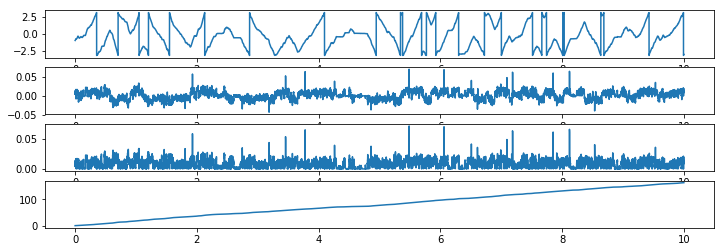

array([ 53.7500714 ,  82.26345971, 116.19487805])

In [6]:
def cumulated_distance_pre(fly_id,condition,ts,display=False):
    
    #First pull up the theta vector for the relevant fly and condition
    bef_theta_filename = 'rev_data_be/'+'theta_be_'+str(condition)+'_'+str(fly_id)+'.txt'
    bef_theta = np.loadtxt(bef_theta_filename)

    bef_t_filename = 'rev_data_be/'+'t_be_'+str(condition)+'_'+str(fly_id)+'.txt'
    bef_t = np.loadtxt(bef_t_filename)
 #     plt.figure(3)
#     plt.plot(bef_t,np.arange(0,10,dt))
    
    #Compute vector of absolute value of delta thetas
    delta_theta = np.gradient(bef_theta)
    delta_theta[np.abs(delta_theta)>1.] = 0.
    abs_delta_theta = np.abs(delta_theta)
    cum_distance = np.cumsum(abs_delta_theta)
    
    if display:
    
        plt.figure(figsize=(12,4))
        plt.subplot(411)
        plt.plot(bef_t,bef_theta)

        plt.subplot(412)
        plt.plot(bef_t,delta_theta)
        
        plt.subplot(413)
        plt.plot(bef_t,abs_delta_theta)
        
        plt.subplot(414)
        plt.plot(bef_t,cum_distance)
        
        plt.show()
        
    
    t_inds = [np.argmin(np.abs(bef_t - t)) for t in ts]
    
    return cum_distance[t_inds]
    
    
    #Select the index corresponding to the inputted t and sum abs_delta_theta up to that index

#     return cum_distance

#demonstrate how this function computes the cumulated distance 
cumulated_distance_pre(15,2,[3.2,5.3,7.1],display=True)

In [93]:
def reversal_raster_by_dist(condition):
 
    #Start a matrix that will host reversal distances for all flies for the condition
    bef_rev_dist_cond = np.full((max_fly_count,max_reversal_count),0.)
    af_rev_times_cond = np.full((max_fly_count,max_reversal_count),0.)
    
    
    #Collect the reversal times for each fly into this matrix
    num_flies = trials_per_cond[condition-1]
    for fly in range(num_flies):
        bef_revs_filename = 'rev_data_be/'+'RE_t_be_'+str(condition)+'_'+str(fly+1)+'.txt'
        bef_revs_time = np.loadtxt(bef_revs_filename)
        
        bef_revs_dist = cumulated_distance_pre(fly+1,condition,bef_revs_time,display=False)
        bef_rev_dist_cond[fly,:len(bef_revs_dist)] =bef_revs_dist
#     for fly in after_fly_inds[condition-1]:
#         af_revs_filename = 'rev_data_af/'+'RE_t_af1_'+str(condition)+'_'+str(fly)+'.txt'
#         af_revs = np.loadtxt(af_revs_filename)
#         af_rev_times_cond[fly-1,:len(af_revs)] = af_revs
    
    plt.figure(figsize=(12,4))
    
    ax = plt.subplot(121)
    plt.title('Pre-Activation Reversals')
    plt.xlim([0,10])
    colors2 = 'black'
    lineoffsets2 = 1
    linelengths2 = 1        
    ax.eventplot(bef_rev_dist_cond[::-1,:], colors=colors2, lineoffsets=lineoffsets2,
                    linelengths=linelengths2)
    plt.ylim([0,25])
    plt.xlabel('Time (min)')
    
#     ax = plt.subplot(122)
#     plt.title('Post-Activation Reversals')
#     plt.xlim([50,60])
#     colors2 = 'black'
#     lineoffsets2 = 1
#     linelengths2 = 1        
#     ax.eventplot(af_rev_times_cond[::-1,:], colors=colors2, lineoffsets=lineoffsets2,
#                     linelengths=linelengths2)
#     plt.ylim([0,25])
#     plt.xlabel('Time (min)')
    
    plt.show()
    
    
    
#start,stop,step,init
# sm=intslider('m',3,10,1,5)
#sfly_sample = intslider('which_fly',0,22,1,0)
condition_toggle = widgets.RadioButtons(options=[('1F',1), ('2F 60',2),
                                          ('2F 90',3)],disabled=False,description='condition')    
sliders = [condition_toggle]#,sfly_sample,m]           
items = [Box([slider]) for slider in sliders]

ui = Box(items, layout=Layout(
    display='flex',
    flex_flow='row',
    border='solid 2px',
    align_items='stretch',
    width='60%'
))

slider_names = [slider.description for slider in sliders]
param_dict =  dict(zip(slider_names,sliders))


out = widgets.interactive_output(reversal_raster_by_dist, param_dict)



display(ui,out)



Box(children=(Box(children=(RadioButtons(description='condition', options=(('1F', 1), ('2F 60', 2), ('2F 90', …

Output()